In [1]:
!pip install matplotlib pandas torch torchmetrics scikit-learn

In [10]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from models import ResNet50, ResNet50BiLSTMAttention
from cnn_lstm import CaiNet
import torch.optim as optim
from collections import OrderedDict

In [11]:
import pickle
from sklearn.model_selection import train_test_split
import os

In [12]:
class SequenceDataset(Dataset):
    def __init__(self, npy_file_paths, labels):
        """
        Args:
            npy_file_paths (list of str): List of file paths for .npy files containing the sequences.
            labels (list): List of labels corresponding to each sequence.
        """
        # Load the sequences and labels
        self.data = [torch.tensor(np.load(file_path)) for file_path in npy_file_paths]
        self.labels = torch.tensor(labels, dtype=torch.float)  # Convert the labels to a tensor

    def __len__(self):
        # Dataset contains as many samples as the number of npy files
        return len(self.data)

    def __getitem__(self, idx):
        # Return the sequence data and its corresponding label
        return self.data[idx], self.labels[idx].long()

# Example usage
npy_file_paths = []
labels = []

root_dir = '../data/mel'
languages = sorted([d for d in os.listdir(root_dir) if d != '.ipynb_checkpoints' and os.path.isdir(os.path.join(root_dir, d))])
print(languages)
num_languages = len(languages)

for i, lang_dir in enumerate(languages):
    lang_path = os.path.join(root_dir, lang_dir)
    if not os.path.isdir(lang_path):
        continue  # Skip non-directory files

    # List all .npy files
    file_names = os.listdir(lang_path)
    full_paths = [os.path.join(lang_path, f) for f in file_names]

    # Extend lists
    npy_file_paths.extend(full_paths)
    labels.extend([i] * len(full_paths))


dataset = SequenceDataset(npy_file_paths, labels)

# dataloader = DataLoader(dataset, batch_size=64)

['chinese', 'english', 'indo', 'malay']


In [13]:
def split_data(dataset):
    # Split dataset into train, validation, and test sets
    train_data, temp_data = train_test_split(dataset, test_size=0.3, shuffle=True)
    valid_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=True)

    # Define batch size for training, full batch for validation and testing
    batch_size = 128

    # Create DataLoader objects
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  # Mini-batch for training
    valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)  # Full batch for validation
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # Full batch for testing

    return train_loader, valid_loader, test_loader

In [14]:
train_loader, valid_loader, test_loader = split_data(dataset)

In [33]:
class Trainer:
    def __init__(self, model, train_loader, valid_loader, test_loader, num_classes=2, num_epochs=10, gradual_unfreezing=False, unfreeze_epochs=[]):
        self.device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.gradual_unfreezing = gradual_unfreezing
        self.unfreeze_epochs = (
            [] if unfreeze_epochs is None or not gradual_unfreezing 
            else sorted(unfreeze_epochs, reverse=True)  # Unfreeze last layers first
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
        self.optimizer.zero_grad()
        self.accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(self.device)
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.unfreeze_from_end = True
        self.best_epoch = 0
        self.l2_lambda = 0.001
        self.layer_groups = self._group_layers()
        self._initialize_requires_grad()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def _group_layers(self):
        layer_dict = OrderedDict()
        for name, param in self.model.named_parameters():
            if name.startswith("resnet."):  # Only include ResNet layers
                # Get the layer name after "resnet."
                layer_name = name.split(".")[1]
                if layer_name not in layer_dict:
                    layer_dict[layer_name] = []
                layer_dict[layer_name].append(param)

        self.head_index = 0
        self.tail_index = len(layer_dict) - 1
        return list(layer_dict.items())


    def _initialize_requires_grad(self):
        if not self.gradual_unfreezing:
            for param in self.model.parameters():
                param.requires_grad = True
        else:
            # Unfreeze 'fc' and first ResNet layer (usually 'conv1' or similar)
            for layer_name, params in self.layer_groups:
                if layer_name == 'fc' or layer_name == self.layer_groups[self.head_index][0]:
                    for param in params:
                        param.requires_grad = True
                else:
                    for param in params:
                        param.requires_grad = False


    def _unfreeze_layer(self):
        if self.head_index > self.tail_index:
            return  # All layers unfrozen

        if self.unfreeze_from_end:
            layer_name, params = self.layer_groups[self.tail_index]
            self.tail_index -= 1
        else:
            layer_name, params = self.layer_groups[self.head_index]
            self.head_index += 1

        for param in params:
            param.requires_grad = True

        self.unfreeze_from_end = not self.unfreeze_from_end  # Alternate next time

    def _unfreeze_layer_by_epoch(self, epoch):
        if epoch in self.unfreeze_epochs:
            self._unfreeze_layer()

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            self._unfreeze_layer_by_epoch(epoch)
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.float().to(self.device), targets.to(self.device)
                pred = self.model(inputs)
                print("train:", pred, targets)
                loss = self.criterion(pred, targets)
                
                # L2 Regularization
                l2_norm = sum(p.pow(2).sum() for p in self.model.parameters())
                loss += self.l2_lambda * l2_norm
                
                self.accuracy_metric.update(pred, targets)
                accuracy = self.accuracy_metric.compute()
                self.accuracy_metric.reset()
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            
            val_loss, val_accuracy = self.validate()
            self.train_losses.append(loss.item())
            self.train_accuracies.append(accuracy.item())
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy.item())
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_state = self.model.state_dict()
                self.best_epoch = epoch + 1
                self._save_best_model()
            
            print(f'Epoch [{epoch+1}/{self.num_epochs}], Training Loss: {loss.item():.4f}, Training Accuracy: {accuracy.item():.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        
        self._load_best_model()
        self.test()

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.valid_loader))
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            pred = self.model(inputs)
            print("valid:", pred, targets)
            loss = self.criterion(pred, targets).item()
            self.accuracy_metric.update(pred, targets)
            accuracy = self.accuracy_metric.compute()
            self.accuracy_metric.reset()
        return loss, accuracy

    def test(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.test_loader))
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            pred = self.model(inputs)
            print("test:", pred, targets)
            loss = self.criterion(pred, targets).item()
            self.accuracy_metric.update(pred, targets)
            accuracy = self.accuracy_metric.compute()
            self.accuracy_metric.reset()
        print(f'Final Test Loss: {loss:.4f}, Final Test Accuracy: {accuracy:.4f}')

    def _save_best_model(self):
        with open("best_model.pkl", "wb") as f:
            pickle.dump({"model_state": self.best_model_state, "epoch": self.best_epoch, "val_loss": self.best_val_loss}, f)

    def _load_best_model(self):
        with open("best_model.pkl", "rb") as f:
            saved_data = pickle.load(f)
            self.model.load_state_dict(saved_data["model_state"])
            print(f"Best Model Achieved at Epoch: {saved_data['epoch']} with Validation Loss: {saved_data['val_loss']:.4f}")

    def plot_losses(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracies(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.train_accuracies, label='Train Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()

c:\Users\muthu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\muthu\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mode: train Shape: torch.Size([11, 1, 128, 241])
ResNet Layer conv1 Output Shape: torch.Size([11, 64, 64, 121])
ResNet Layer bn1 Output Shape: torch.Size([11, 64, 64, 121])
ResNet Layer relu Output Shape: torch.Size([11, 64, 64, 121])
ResNet Layer maxpool Output Shape: torch.Size([11, 64, 32, 61])
ResNet Layer layer1 Output Shape: torch.Size([11, 256, 32, 61])
ResNet Layer layer2 Output Shape: torch.Size([11, 512, 16, 31])
ResNet Layer layer3 Output Shape: torch.Size([11, 1024, 8, 16])
ResNet Layer layer4 Output Shape: torch.Size([11, 2048, 4, 8])
ResNet Layer avgpool Output Shape: torch.Size([11, 2048, 1, 7])
ResNet Output Shape: torch.Size([11, 2048, 1, 7])
ResNet Output Shape after reshaping: torch.Size([11, 7, 2048])
train: tensor([[ 0.0077, -0.0204,  0.0903,  0.0296],
        [-0.0133, -0.0425,  0.0255,  0.0276],
        [ 0.0216,  0.0475,  0.0299,  0.0433],
        [ 0.0166, -0.0339,  0.0367,  0.0345],
        [ 0.0575, -0.0511,  0.0560,  0.0543],
        [ 0.0219,  0.0571,  0.06

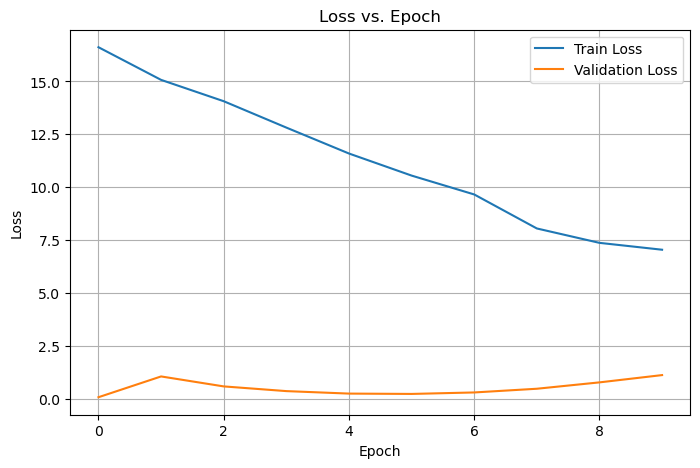

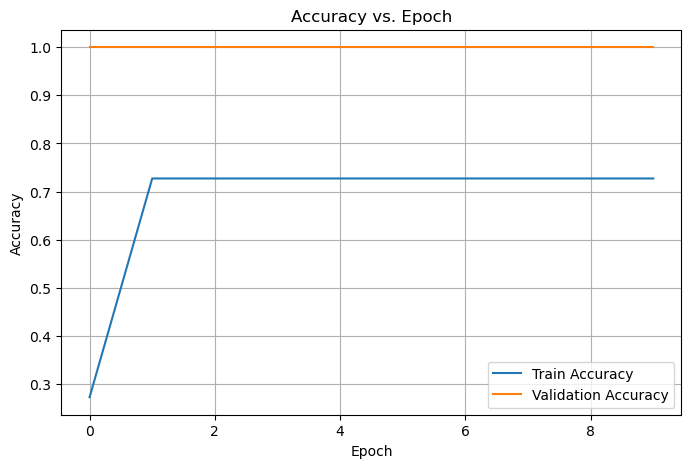

In [34]:
trainer = Trainer(ResNet50BiLSTMAttention(classes=num_languages), train_loader, valid_loader, test_loader, num_classes = num_languages, num_epochs=10, gradual_unfreezing=True, unfreeze_epochs=[2, 4, 6])
trainer.train()
trainer.plot_losses()
trainer.plot_accuracies()